# MONTE CARLO DROPOUT X JCGM
Incerteza Epistêmica em Redes Neurais - Gerson Eduardo de Mello 

Esta é uma aplicação do método de incerteza em redes neurais JCGM e MC dropout proposto por Yarin Gal. O Dataset escolhido foi O 
Airfoil Self-Noise Data Set (http://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise ) retirado do UCL Machine Learn Repository. A variável predita escolhida foi a "Pressure" e todas as demais foram consideradas como variáveis preditoras. 

Este artigo aborda a aplicação da incerteza em aprendizagem profunda denrto do domínio das
ciências físicas. O estudo destaca a importância de avaliar e quantificar as incertezas associadas
a essas previsões, considerando tanto as incertezas epistêmicas relacionadas ao conhecimento do
modelo quanto as incertezas aleatórias provenientes dos dados utilizados. A proposta consiste em
aplicar uma metodologia já consolidada nas ciências físicas, referenciada no JCGM 100:2008, com
adaptações específicas para estimar a incerteza aleatória que é proveniente dos dados, epistêmica
oriunda do modelo e preditiva (relacionadas à previsão) de uma rede neural treinada. O objetivo
principal é desenvolver um algoritmo de fácil aplicação, sem custo computacional que trabalhe
em paralelo com o algoritmo de predição da própria rede neural, permitindo associar a cada valor
predito um intervalo de abrangência de 95% de probabilidade em torno desse valor. Para validar
a eficácia dessa abordagem, realizaremos uma comparação entre a metodologia JCGM 100:2008
e uma abordagem Bayesiana, com foco no método Monte Carlo Dropout, para estimar a incerteza
epistêmica. Utilizaremos um conjunto de dados disponibilizado pelo UC Irvine Machine Learning
Repository como benchmark para avaliar e comparar os resultados obtidos por essas abordagens.A
análise das incertezas provenientes de uma mesma rede neural demonstra que o método JCGM
apresenta-se promissor às condições reais no domínio das ciências físicas. A disponibilidade do código
em  permite a reprodução dos experimentos e facilita o acesso à metodologia proposta.Este estudo contribui para aprimorar o
uso da aprendizagem profunda nas ciências físicas, fornecendo uma compreensão mais completa das
incertezas associadas às previsões, o que é essencial para a confiabilidade e aplicabilidade desses
modelos em diversas áreas de pesquisa

# Manipulando os dados 

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-learn



%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [157]:
# importando os dados  

In [158]:
df=pd.read_csv('airfoil.csv')

In [159]:
df

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Após a avaliação da distribuição dos dados para cada uma das variáveis, pode-se aplicar a normalização que é a mais apropriada do que a padronização uma vez que oas distribuições não seguem uma normalidade

In [160]:
from sklearn.preprocessing import MinMaxScaler 

In [161]:
scaler=MinMaxScaler(feature_range=(0,1))
df_n = scaler.fit_transform(df)
print(df_n)

[[0.03030303 0.         1.         1.         0.03900472 0.60682852]
 [0.04040404 0.         1.         1.         0.03900472 0.58023772]
 [0.0530303  0.         1.         1.         0.03900472 0.60018082]
 ...
 [0.19191919 0.7027027  0.27272727 0.19949495 0.90411066 0.08572872]
 [0.24242424 0.7027027  0.27272727 0.19949495 0.90411066 0.07562422]
 [0.30808081 0.7027027  0.27272727 0.19949495 0.90411066 0.02191081]]


In [162]:
df_n=pd.DataFrame(df_n)

In [163]:
y=df_n[5]

In [164]:
X=df_n[df_n.columns[0:5]]

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True, random_state=32)

# Construção e treino da rede neural 

In [166]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [167]:
#construimos a rede neural

In [168]:
n_input = 5  # numero de entradas das rede neural 
num_out = 1
p_dropout = 0.5 # probabilidade dropout 

lbd = 1e-4  # L2- força de regularização 

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3) 

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 100)               600       
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,801
Trainable params: 10,801
Non-trai

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Treino RNN

In [169]:
epochs = 10000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 1,
            epochs=epochs,
            verbose=0)

# Avaliamos a performance do modelo

In [170]:
from sklearn import metrics

y_hat_train = model.predict(X_train)# passamos  o conjunto de treino pela rede e obtemos as predições 


46/46 [==============================] - 0s 627us/step


In [171]:
y_hat_test = model.predict(X_test)# passamos  o conjunto de teste pela rede e obtemos as predições


1/1 [==============================] - 0s 43ms/step


In [172]:
# métricas do treino

In [173]:
MAE_T=metrics.mean_absolute_error(y_train, y_hat_train)
R2_T=metrics.r2_score(y_train, y_hat_train);
RMSE_T=metrics.mean_squared_error(y_train, y_hat_train)

In [174]:
MAE_T,R2_T,RMSE_T

(0.049600746011208306, 0.8720845905394958, 0.004337062347938771)

In [175]:
# métricas do teste

In [176]:
MAE_t=metrics.mean_absolute_error(y_test, y_hat_test)
R2_t=metrics.r2_score(y_test, y_hat_test);
RMSE_t=metrics.mean_squared_error(y_test, y_hat_test)

In [177]:
MAE_t,R2_t,RMSE_t

(0.04390899500191556, 0.8605250319982722, 0.0028127861731476024)

# Determinação do erro aleatório e erro sistemático em todo o dataset

In [178]:
previsão=model.predict(X[:1503])# passando todos os dados pela rede ( sem distinção de treino e teste)

47/47 [==============================] - 0s 629us/step


In [179]:
previsão=pd.DataFrame(previsão)

In [180]:
df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão 

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\1795452580.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão


In [181]:
df.resume4.columns=['x1','x2','x3','x4','x5','y','predict']

In [182]:

erro=df.resume4['predict']-df.resume4['y']#determinando o erro emtre o real e a predição 

es=erro.loc[:,].mean()

ea=erro.loc[:,].std()


In [183]:
erro=pd.DataFrame(erro)

In [184]:
ea

0.06352159421842665

In [185]:
es

0.016532248389459842

In [186]:
erro.describe()# confirmando os resultados

,0
count,1503.000000
mean,0.016532
std,0.063522
min,-0.338392
25%,-0.020164
50%,0.017581
75%,0.052171
max,0.237939


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


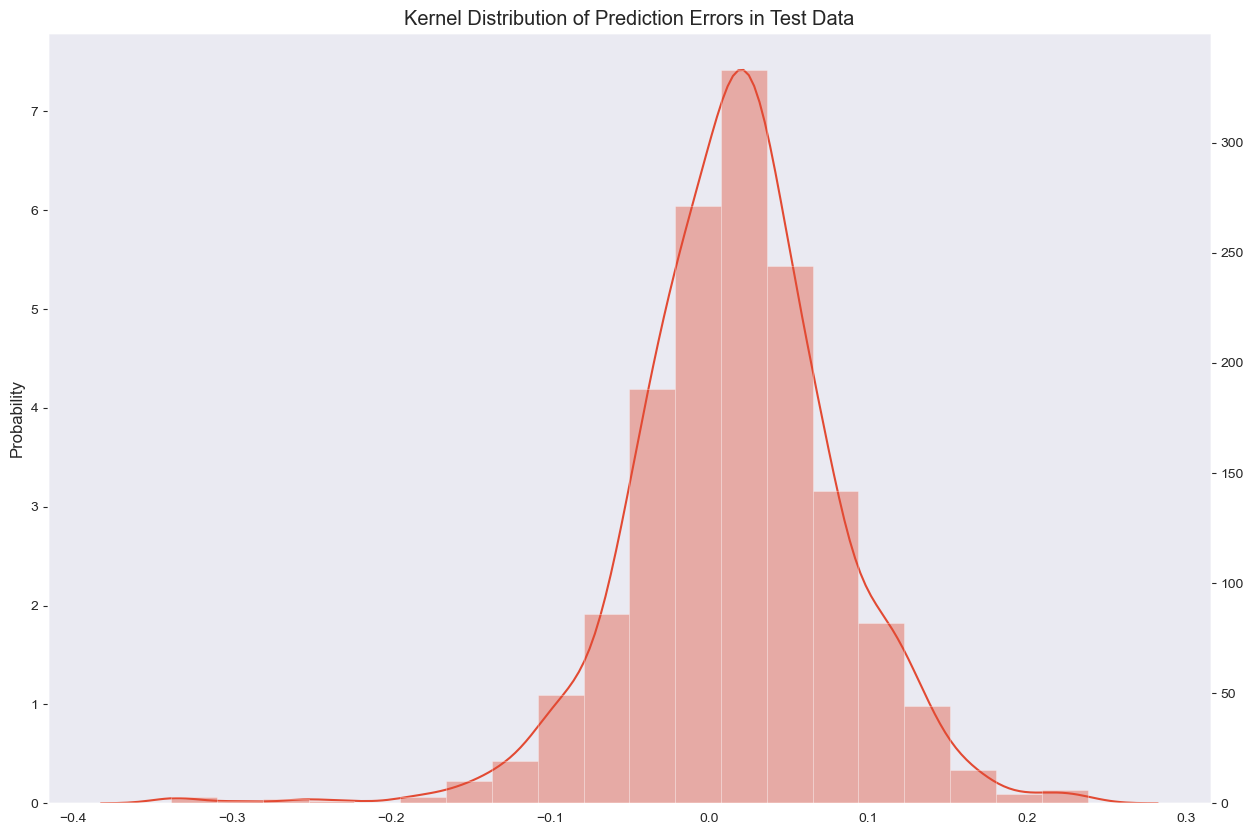

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [188]:
# elaboração do gráfico ordenando os dados em ordem e plotando os valores reais e predito no conjunto de teste 

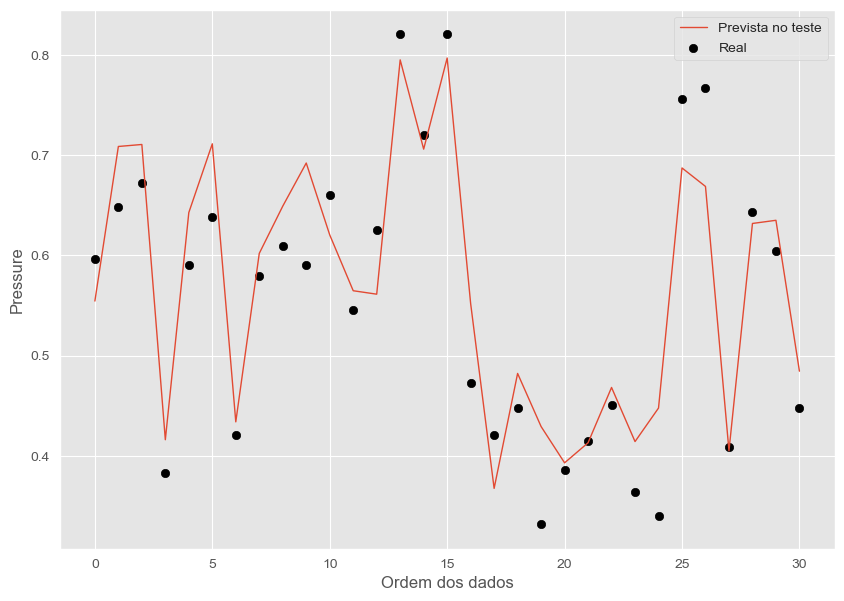

In [189]:
# avaliação conjunto de teste
n = 31
plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test, label="Prevista no teste", lw=1)#y_hat_test é a prediçã osobre os dados de teste
plt.scatter(range(n), y_test, color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

Acima, a previsão é feita da forma tradicional, isto é, colocando a probabilidade de Dropout em 0%, usando assim toda a capacidade da rede. Esse é o padrão do Keras e precisaremos rescrevê-lo para implementar Monte-Carlo Dropout, no qual mantemos as probabilidades de Dropout de treino também durante as previsões. Abaixo, vamos definir uma função que retornará a última camada da rede, (as previsões) dada a camada de entrada (as variáveis). Além disso, vamos definir que está função será usada tal como durante o treinamento, passando K.learning_phase().
Abaixo realizamos 1000 forwad-passes pela rede neural e obtemos 1000 previsões para cada ponto.

# MC DROPOUT

In [190]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_test.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [191]:
y_hat_mc.shape

(31, 1000)

In [192]:
y_hat_mc=pd.DataFrame(y_hat_mc)

In [193]:
y_hat_mc # são as 1000 previsões realizadas pela rede Dropout para cada vetor teste

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.568330,0.571563,0.581745,0.550581,0.472910,0.626892,0.683555,0.535916,0.662585,0.547080,...,0.636627,0.573292,0.581981,0.542531,0.639108,0.498573,0.649142,0.552716,0.578551,0.699796
1,0.650069,0.677058,0.679912,0.562184,0.709944,0.711324,0.665472,0.750089,0.730066,0.642772,...,0.728424,0.674877,0.676183,0.688785,0.714902,0.682549,0.712278,0.635024,0.626062,0.698311
2,0.675750,0.716086,0.726937,0.681925,0.717877,0.674722,0.766245,0.689070,0.708544,0.698331,...,0.747505,0.775283,0.719587,0.665371,0.756765,0.754799,0.712610,0.704792,0.685638,0.667370
3,0.604817,0.413282,0.375471,0.444240,0.413586,0.427043,0.383092,0.381310,0.446786,0.416057,...,0.398200,0.369559,0.343577,0.359456,0.664879,0.387384,0.362438,0.402873,0.381106,0.412329
4,0.575576,0.623756,0.559486,0.635941,0.601951,0.677004,0.588084,0.566441,0.554414,0.643633,...,0.630731,0.595663,0.665040,0.497800,0.603568,0.574359,0.600408,0.617162,0.657093,0.591519
5,0.671815,0.727743,0.616796,0.735388,0.664553,0.693172,0.655928,0.697391,0.731107,0.519259,...,0.682471,0.704309,0.688385,0.668494,0.691706,0.666871,0.684042,0.620328,0.698965,0.666422
6,0.332284,0.377336,0.449455,0.524933,0.509824,0.373428,0.279966,0.463784,0.457880,0.418045,...,0.474924,0.374156,0.363853,0.324546,0.390314,0.433823,0.430785,0.395083,0.365284,0.450243
7,0.641149,0.666895,0.590493,0.657802,0.633780,0.665021,0.673946,0.606240,0.587708,0.563284,...,0.639259,0.552405,0.680606,0.574556,0.626242,0.658489,0.563824,0.684599,0.572161,0.580198
8,0.585075,0.570996,0.672701,0.540893,0.645625,0.616403,0.641089,0.675050,0.643584,0.506667,...,0.647565,0.611879,0.547423,0.636860,0.639068,0.599939,0.589128,0.643196,0.601251,0.608737
9,0.662998,0.664371,0.690280,0.656491,0.688844,0.595355,0.736535,0.706978,0.635656,0.669164,...,0.665205,0.704613,0.581138,0.684206,0.691389,0.619987,0.619568,0.634726,0.642120,0.649992


In [194]:
yhat=pd.DataFrame(y_hat_mc)

In [195]:
#vamos calcular a média dos 1000 resultados para cada amostra de teste

In [196]:
yhat['mean']=yhat.apply(np.mean,axis=1)

In [197]:
#separamos novamente os 1000 resultados retitrando a coluna média 

In [198]:
yhatd=yhat.iloc[:,0:1000]

In [199]:
#vamos calcular o desvio padrão dos 1000 resultados dos dados de teste

In [200]:
yhatd['std']=yhatd.apply(np.std,axis=1)

In [201]:
#Abaixo os valores reais para y do conjunto de teste

In [202]:
y_test=pd.DataFrame(y_test)

In [203]:
#resetando o índice 

In [204]:
y_test=y_test.reset_index(drop=True)

In [205]:
#retirado a coluna 0

In [206]:
mean=yhat.iloc[:,1000]

In [207]:
mean=pd.DataFrame(mean)

In [208]:
desvpad=yhatd.iloc[:,1000]

In [209]:
desvpad=pd.DataFrame(desvpad)

# Determinação do erro aleatório e sistemático somente no teste  

In [210]:
#colocar tudo em uma tabela

In [211]:
df.resume=pd.concat([y_test,mean,desvpad],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\1750862409.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume=pd.concat([y_test,mean,desvpad],axis=1)


In [212]:
erro2=df.resume['mean']-df.resume[5]


In [213]:
erro2

0    -0.020680
1     0.032933
2     0.026093
3     0.042120
4     0.031073
5     0.040576
6     0.009897
7     0.026267
8     0.020251
9     0.061796
10   -0.066961
11    0.033825
12   -0.050662
13   -0.065709
14   -0.047860
15   -0.053372
16    0.091395
17   -0.030481
18    0.029226
19    0.145381
20    0.014580
21   -0.000915
22    0.022085
23    0.050911
24    0.111056
25   -0.099427
26   -0.082685
27    0.001409
28   -0.004201
29    0.008770
30    0.033301
dtype: float64

In [214]:
es2=erro2.loc[:,].mean()

ea2=erro2.loc[:,].std()


In [215]:
es2

0.00999983636372267

In [216]:
es

0.016532248389459842

In [217]:
ea2

0.05506784882455431

In [218]:
ea

0.06352159421842665

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


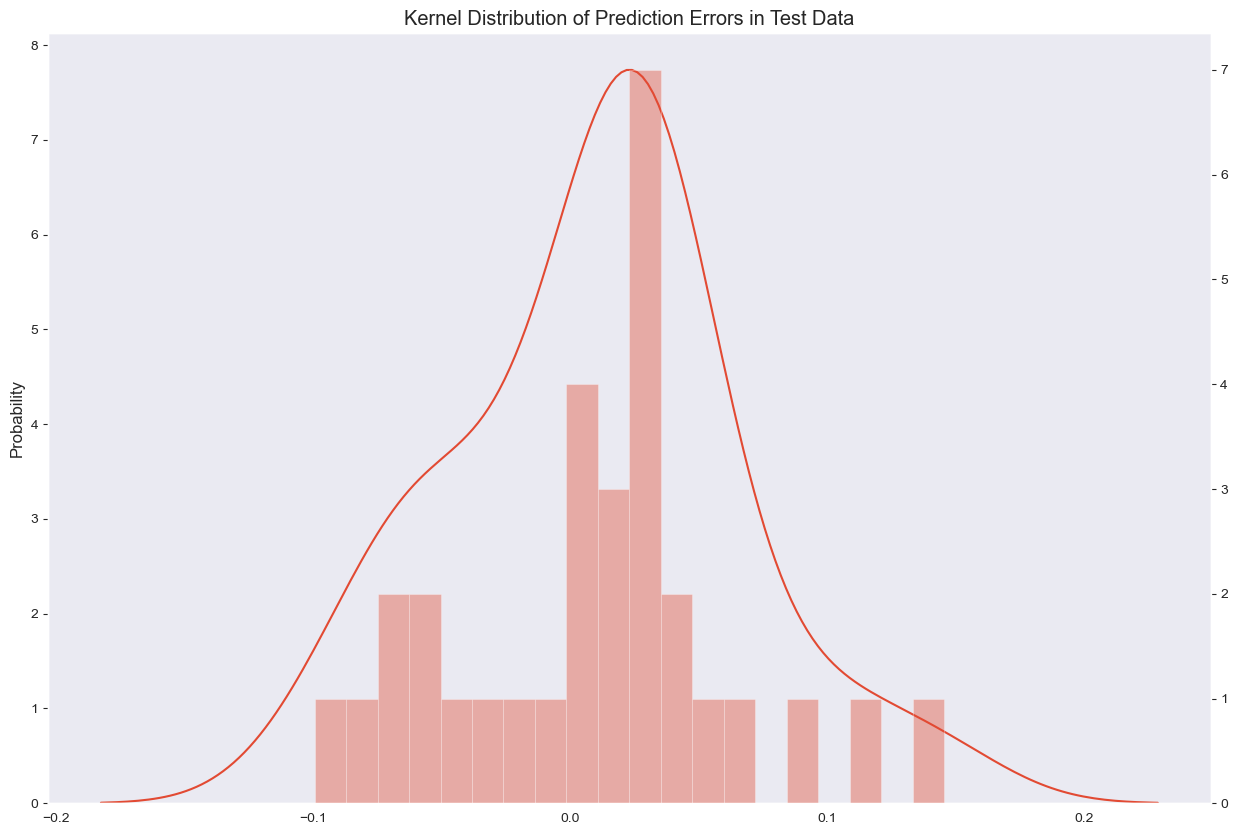

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro2, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro2, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


# Determinação erro aleatório e sistemático em todos os dados (Dropout) 

In [220]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mct = np.array([predict_stochastic([X]) for _ in range(T)])

y_hat_mct = y_hat_mct.reshape(-1, y.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [221]:
yhatt=pd.DataFrame(y_hat_mct)

In [222]:
yhatt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.651318,0.696269,0.640605,0.690212,0.611140,0.654507,0.694109,0.580182,0.644560,0.670778,...,0.620375,0.643965,0.669791,0.636895,0.631615,0.660473,0.641625,0.593495,0.671512,0.629324
1,0.689759,0.682328,0.575366,0.617697,0.638975,0.676983,0.634764,0.673705,0.639407,0.694697,...,0.639118,0.660430,0.605706,0.679610,0.637235,0.667873,0.700482,0.589551,0.636877,0.640355
2,0.639363,0.642168,0.707254,0.653966,0.623368,0.694998,0.589036,0.620073,0.710667,0.631178,...,0.704423,0.687341,0.708745,0.630633,0.629016,0.670971,0.672855,0.675260,0.575504,0.644637
3,0.666794,0.667647,0.647714,0.644097,0.683501,0.602059,0.639230,0.655289,0.647565,0.668227,...,0.656740,0.652853,0.711313,0.637906,0.687474,0.671752,0.670081,0.630705,0.619577,0.651729
4,0.652281,0.621745,0.627851,0.591922,0.642549,0.638254,0.601949,0.593099,0.625559,0.659640,...,0.588850,0.614655,0.592527,0.618077,0.652908,0.609518,0.610055,0.581332,0.646147,0.581549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.262824,0.723161,0.168714,0.238285,0.169764,0.198488,0.319485,0.265368,0.228873,0.281992,...,0.320616,0.177443,0.289545,0.319463,0.438248,0.280108,0.370899,0.522282,0.356037,0.396653
1499,0.173532,0.278243,0.161185,0.233234,0.034492,0.118394,0.582569,0.125239,0.262651,0.221891,...,0.508590,0.543870,0.342265,0.109016,0.178011,0.230225,0.149859,0.137098,0.278651,0.258695
1500,0.225082,0.157956,0.030490,0.350300,0.550297,0.299289,0.103436,0.184894,0.281879,0.472316,...,0.231858,0.089105,0.044600,0.234630,0.121410,0.017906,0.287940,0.278591,0.147510,0.122135
1501,-0.003315,0.281438,0.296517,0.198487,0.091603,0.026478,-0.046932,-0.043149,0.369821,0.180835,...,0.100740,0.065237,0.263705,0.282001,0.058202,-0.049904,0.092096,-0.034449,0.145440,0.132663


In [223]:
meanyhatt=yhatt.apply(np.mean,axis=1)

In [224]:
desvyhatt=yhatt.apply(np.std,axis=1)

In [225]:
erro3=meanyhatt-y

In [226]:
erro3

0       0.026898
1       0.068125
2       0.049053
3      -0.001518
4      -0.017466
          ...   
1498    0.094634
1499    0.091364
1500    0.116036
1501    0.095991
1502    0.132652
Length: 1503, dtype: float64

In [227]:
es3=erro3.loc[:,].mean()

ea3=erro3.loc[:,].std()


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


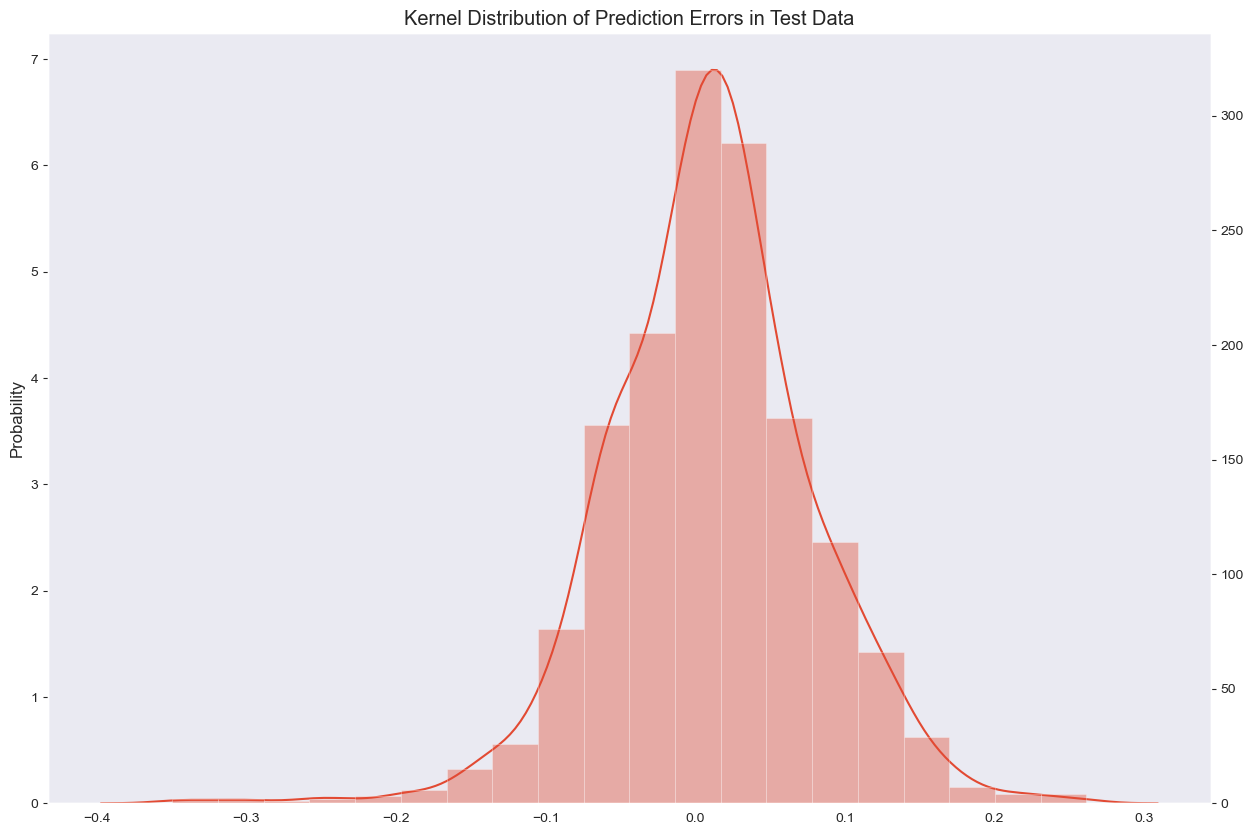

In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro3, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro3, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [229]:
#Computamos média e variância para cada ponto no set de teste.

In [230]:
es3

0.009852042389725701

In [231]:
ea3

0.06870124541395085

In [232]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1) # média das 1000 previsões para cada ponto 
y_hat_test_variance = np.var(y_hat_mc, axis=1) 
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1  # variância das 1000 previsões para cada ponto 

In [233]:
metrics.mean_absolute_error(y_test, y_hat_test_mean)

0.04373871753741207

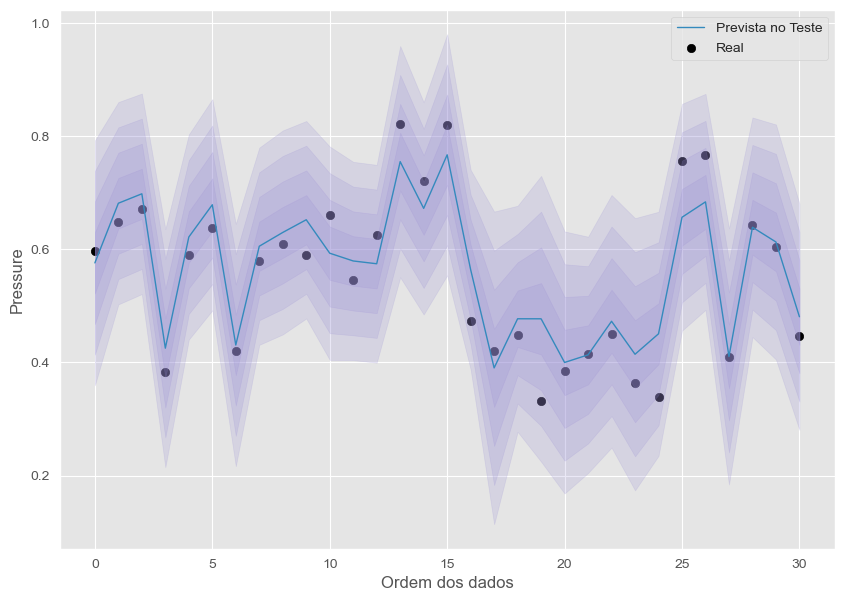

In [234]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista no Teste", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

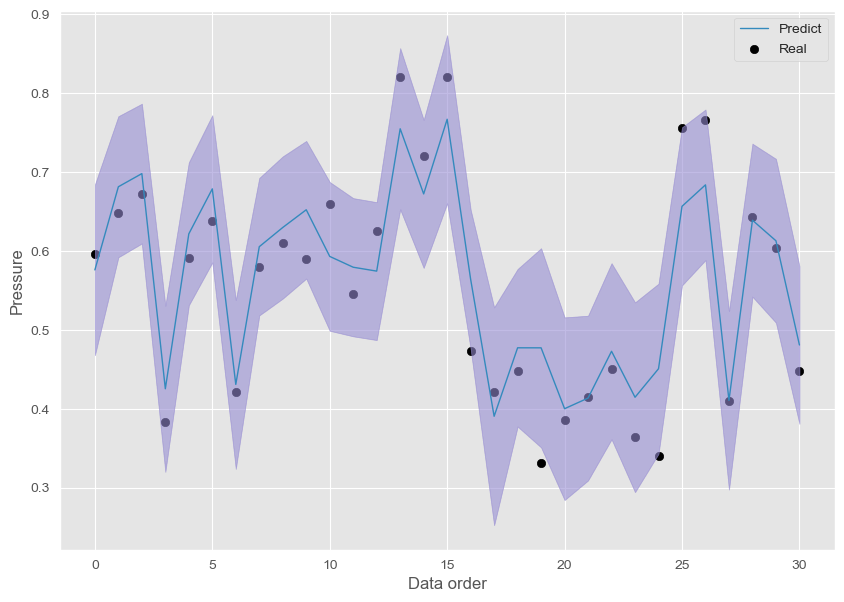

In [235]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Predict", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma, alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

# Determinação das incertezas da rede método JCGM 100: 2008

In [236]:
X_test=X_test.reset_index(drop=True)

In [237]:

 previsão=model.predict(X_test[:31])


1/1 [==============================] - 0s 15ms/step


In [238]:
colnames=["Predict"]

In [239]:
previsão1=pd.DataFrame(previsão, columns=colnames)

In [240]:
df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\3988421289.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)


In [241]:
#criar a coluna de predict delta x1 

In [242]:
#método numerico para derivadas parcias: método das diferenças onde h=0.000001

In [243]:
h1=0.000001
h2=0.000001
h3=0.000001
h4=0.000001
h5=0.000001

In [244]:
deltax1=X_test[:31]+np.array([h1,0,0,0,0])

In [245]:
previsãodeltax1=model.predict(deltax1[:31])


1/1 [==============================] - 0s 16ms/step


In [246]:
colnames=["Predict Deltax1"]
previsãodeltax1=pd.DataFrame(previsãodeltax1, columns=colnames)

In [247]:
#criar a coluna de predict delta x2

In [248]:
#incerteza de x2 (medidor de ângulo)

In [249]:
deltax2=X_test[:31]+np.array([0,h2,0,0,0])

In [250]:
previsãodeltax2=model.predict(deltax2[:31])

1/1 [==============================] - 0s 15ms/step


In [251]:
colnames=["Predict Deltax2"]
previsãodeltax2=pd.DataFrame(previsãodeltax2, columns=colnames)

In [252]:
#criar a coluna de predict delta x3

In [253]:
#incerteza de x3 (medidor de comprimento)

In [254]:
deltax3=X_test[:31]+np.array([0,0,h3,0,0])

In [255]:
previsãodeltax3=model.predict(deltax3[:31])

1/1 [==============================] - 0s 15ms/step


In [256]:
colnames=["Predict Deltax3"]
previsãodeltax3=pd.DataFrame(previsãodeltax3, columns=colnames)

In [257]:
#criar a coluna de predict delta x4

In [258]:
#incerteza de x4 (medidor de velocidade).

In [259]:
deltax4=X_test[:31]+np.array([0,0,0,h4,0])

In [260]:
previsãodeltax4=model.predict(deltax4[:31])

1/1 [==============================] - 0s 16ms/step


In [261]:
colnames=["Predict Deltax4"]
previsãodeltax4=pd.DataFrame(previsãodeltax4, columns=colnames)

In [262]:
#criar a coluna de predict delta x5

In [263]:
#incerteza de x5 (medidor de sucção)

In [264]:
deltax5=X_test[:31]+np.array([0,0,0,0,h5])

In [265]:
previsãodeltax5=model.predict(deltax5[:31])

1/1 [==============================] - 0s 15ms/step


In [266]:
colnames=["Predict Deltax5"]
previsãodeltax5=pd.DataFrame(previsãodeltax5, columns=colnames)

In [267]:
df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\2651709830.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)


In [268]:
df.total['c1']=(df.total['Predict Deltax1']-df.total['Predict'])/h1


In [269]:
df.total['c2']=(df.total['Predict Deltax2']-df.total['Predict'])/h2


In [270]:
df.total['c3']=(df.total['Predict Deltax3']-df.total['Predict'])/h3

In [271]:
df.total['c4']=(df.total['Predict Deltax4']-df.total['Predict'])/h4

In [272]:
df.total['c5']=(df.total['Predict Deltax5']-df.total['Predict'])/h5

In [273]:
#cálculo da incerteza combinada : incerteza expandida de x1 a x5  desvio padrão do erro sistemático
#x1: medidor de frequencia sonora.5% do valor médio da escala
#x2: medidor de angulo :5% do valor médio da escala
#x3: medidor de comprimento 5% do valor médio da escala
#x4: medidor de velocidade do vento Pesquisando a incerteza em tuneis de vento chega a 15% do resultado . Como a velocidade média é em torno de 40 m/s estimou-se em +-6m/s²
#x5: medidor de sucção 5% do valor médio da escala
#y: pressão somora: 5% do valor médio da escala
 

In [274]:
upx1=0.0003468*0.5/2
upx2=0.00488*0.5/2
upx3=0.001470*0.5/2
upx4=0.01966*0.5/2
upx5=0.1*0.5/2
upy=0.008*0.5/2

In [275]:
df_n.rename(columns={
    0: 'Frequency',1:'Angle',2:'Length',3:'Velocity',4:'Suction Side',5:'Pressure'
   
},inplace=True)

In [276]:
correlation= df_n.corr()

In [277]:
correlation

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
Frequency,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Suction Side,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
Pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [278]:
r_as=correlation['Angle']['Suction Side']

In [279]:
r_al=correlation['Angle']['Length']

<AxesSubplot:>

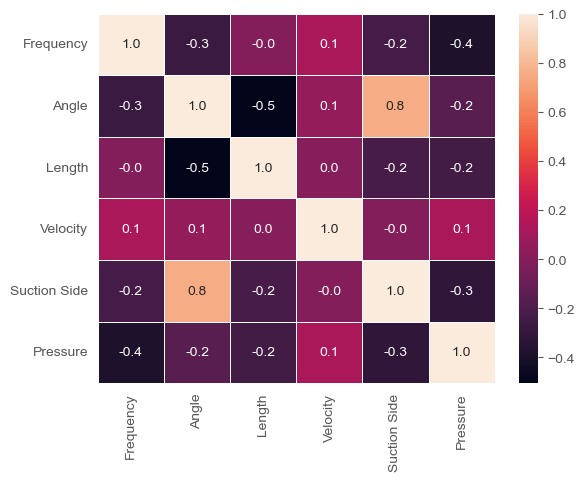

In [280]:
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)

plot

In [281]:
cov= df_n.cov()

In [282]:
cov

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
Frequency,0.025351,-0.011578,-0.000195,0.008369,-0.008305,-0.011412
Angle,-0.011578,0.071066,-0.045059,0.006160,0.045528,-0.007634
Length,-0.000195,-0.045059,0.112085,0.000499,-0.016760,-0.014504
Velocity,0.008369,0.006160,0.000499,0.154647,-0.000354,0.009025
Suction Side,-0.008305,0.045528,-0.016760,-0.000354,0.051387,-0.013002
Pressure,-0.011412,-0.007634,-0.014504,0.009025,-0.013002,0.033651


# Determinação da incerteza aleátória, epistêmica e Preditiva 

In [283]:
ucca=((df.total['c1']*upx1)**2+
                   (df.total['c2']*upx2)**2+
                   (df.total['c3']*upx3)**2+
                   (df.total['c4']*upx4)**2+
                   (df.total['c5']*upx5)**2+2*df.total['c1']*df.total['c5']*upx1*upx5*r_as+
                   2*df.total['c1']*df.total['c2']*upx1*upx2*r_al+upy**2)**0.5

In [284]:
ucce=((ea)**2)**0.5

In [285]:
ucc=(ucca**2+ucce**2)**0.5

In [286]:
U= 2*ucc+abs(es)

In [287]:
df.total['ucca']=ucca
df.total['ucce']=ucce
df.total['ucc']=ucc
df.total['U']=U

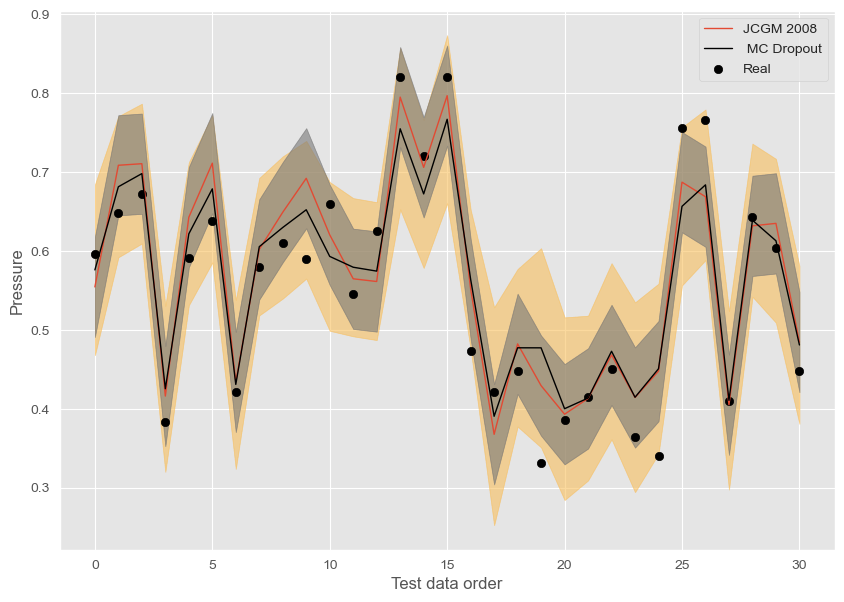

In [288]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, df.total['Predict'], label="JCGM 2008", color="C7", lw=1)
plt.plot(t, mu, label=" MC Dropout", color="Black", lw=1)
for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma , alpha=0.2, color="C11")
for shade in range(1, 5):
    plt.fill_between(t, df.total['Predict']-df.total['ucce'], df.total['Predict']+df.total['ucce'], alpha=0.2, color="C3")

plt.scatter(t, df.total[5], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [289]:
MCCC=pd.concat([df.total[5],df.total['Predict'],df.total['ucca'],df.total['ucce'],df.total['ucc'],df.total['U']],axis=1)

In [290]:
# Definir os nomes das colunas
nomes_colunas = ['Real','GUM Predict','GUM Aleatoric Uncertainty','GUM Epistemic Uncertainty','GUM Preditive Uncertainty','GUM_U_exp']

# Atribuir os nomes das colunas ao DataFrame
MCCC.columns = nomes_colunas



In [291]:
MCCC

,Real,GUM Predict,GUM Aleatoric Uncertainty,GUM Epistemic Uncertainty,GUM Preditive Uncertainty,GUM_U_exp
0,0.596591,0.554352,0.002470,0.063522,0.063570,0.143671
1,0.648363,0.708528,0.007749,0.063522,0.063992,0.144517
2,0.671870,0.710515,0.010640,0.063522,0.064407,0.145345
3,0.383147,0.416052,0.023968,0.063522,0.067893,0.152318
4,0.590555,0.642647,0.025493,0.063522,0.068446,0.153424
5,0.638046,0.711185,0.050973,0.063522,0.081444,0.179421
6,0.420906,0.433876,0.056712,0.063522,0.085154,0.186840
7,0.579068,0.601902,0.024291,0.063522,0.068008,0.152548
8,0.609434,0.649023,0.009437,0.063522,0.064219,0.144970
9,0.590342,0.692019,0.009437,0.063522,0.064219,0.144970


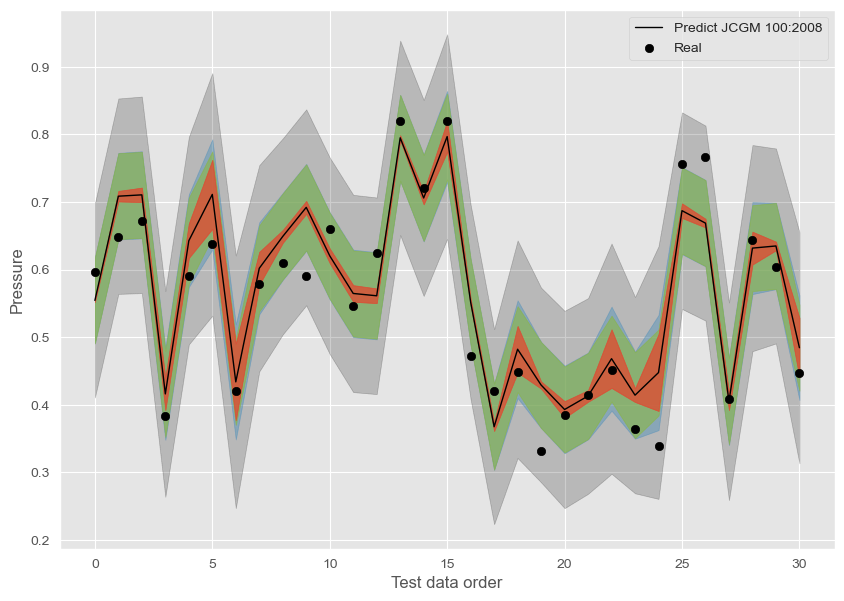

In [292]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='Predict JCGM 100:2008', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM_U_exp'],  MCCC['GUM Predict']+MCCC['GUM_U_exp'], alpha=0.05, color="black")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Preditive Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Preditive Uncertainty'], alpha=0.1, color="C8")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Epistemic Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Epistemic Uncertainty'], alpha=0.2, color="C5")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Aleatoric Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Aleatoric Uncertainty'], alpha=0.3, color="C7")

plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()